In [4]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
model_resnet = models.resnet18(weights='IMAGENET1K_V1')
for param in model_resnet.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 3)  #mengganti jumlah classifier sesuai output kelas

model_resnet = model_resnet.to(device)

loss_fn = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(model_resnet.fc.parameters(), lr=0.0001, momentum=0.9)

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    # transfoarms.RandomHorizontalFlip(),
    transforms.ToTensor(),  
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])        
])

In [7]:
# Create an ImageFolder dataset
# Create ImageFolder datasets
train_dataset = ImageFolder(root='vegetable_images/train', transform=transform)
val_dataset = ImageFolder(root='vegetable_images/validation', transform=transform)
test_dataset = ImageFolder(root='vegetable_images/test', transform=transform)

# Create a data loader
batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

In [9]:
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(5):  # loop over the dataset multiple times
    model_resnet.train()
    running_loss, running_acc = 0.0, 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += calculate_accuracy(outputs, labels)
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(running_acc / len(train_loader))

    model_resnet.eval()
    val_loss, val_acc = 0.0, 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            val_acc += calculate_accuracy(outputs, labels)

            _, preds = torch.max(outputs, 1)  
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc / len(val_loader))
    

    print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.2f}, Train Acc: {train_accs[-1]:.2f}, Val Loss: {val_losses[-1]:.2f}, Val Acc: {val_accs[-1]:.2f}')

Epoch 1, Train Loss: 0.90, Train Acc: 0.63, Val Loss: 0.55, Val Acc: 0.94
Epoch 2, Train Loss: 0.45, Train Acc: 0.96, Val Loss: 0.30, Val Acc: 0.99
Epoch 3, Train Loss: 0.30, Train Acc: 0.98, Val Loss: 0.21, Val Acc: 0.99
Epoch 4, Train Loss: 0.23, Train Acc: 0.99, Val Loss: 0.16, Val Acc: 1.00
Epoch 5, Train Loss: 0.20, Train Acc: 0.99, Val Loss: 0.13, Val Acc: 1.00


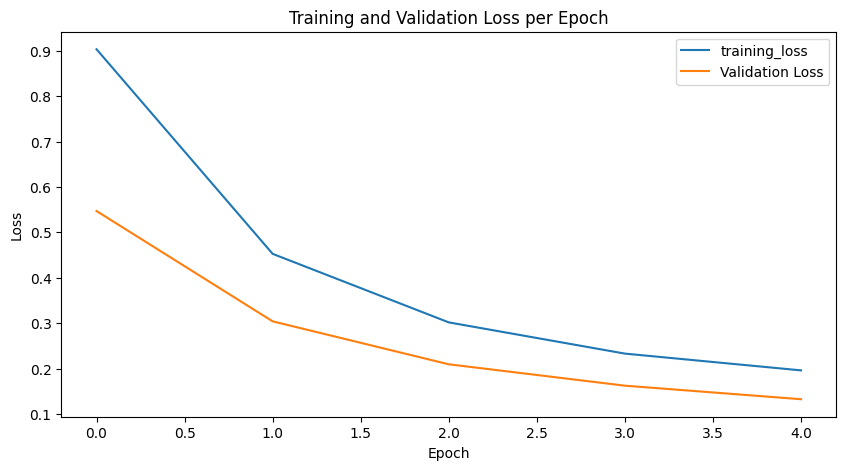

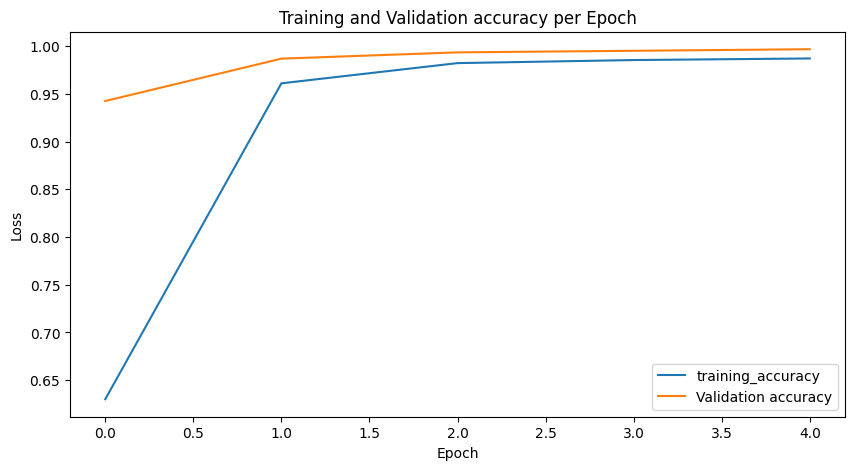

In [10]:
import matplotlib.pyplot as plt
# Plot training dan validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label = 'training_loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Plot training dan validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label = 'training_accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.title('Training and Validation accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
def calculate_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    return f1, cm

f1, cm = calculate_metrics(all_labels, all_preds)
print(f'Validation F1 Score: {f1:.2f}')

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               )
disp.plot()
plt.show()

NameError: name 'all_labels' is not defined

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(all_labels, all_preds, target_names=["0", "1", "2"])
print(report)

In [ ]:
torch.save(model_resnet.state_dict(), 'transfer_learning_resnet.pth')  #save the model has been trained